## Time measurement of algorithms execution

In [44]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gym
import slimevolleygym
from slimevolleygym import SurvivalRewardEnv
from algorithms import *

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import A2C, PPO, DQN, SAC

import time

plt.style.use('seaborn')

# Define our input folders and output files
DATADIR = join('..', 'data')
FIGDIR = join('..', 'figures')

### Classic algorithms

In [2]:
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

slime_env = SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0')))

In [3]:
class BoundFeaturizer:
    def __init__(self, observation_space, partitions = 10, sigma = 0.1, bound = 5.0):
        self.n_dim = len(observation_space.low)
        self.sigma = sigma
        offset, scale_factor = [], []
        for i in range(self.n_dim):
            lower_bound = max(-1*bound, observation_space.low[i])
            upper_bound = min(bound, observation_space.high[i])
            offset.append(-1* lower_bound)
            scale_factor.append(1/(upper_bound - lower_bound))
        self.offset = np.array(offset, dtype=np.float_)
        self.scale_factor = np.array(scale_factor ,dtype=np.float_)
        scale = np.linspace(1.0/partitions,1.0,partitions) - 0.5/partitions
        self.landmarks = np.array(list(product(scale, repeat=self.n_dim)))
        self.n_parameters = partitions**self.n_dim
    
    def feature_vector(self, s):
        s = (s + self.offset) * self.scale_factor
        dist = (self.landmarks - s)**2
        f = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return f
    
class ClusteringFeaturizer:
    def __init__(self, observation_space, centroids, sigma=0.5):
        self.n_dim = len(observation_space.low)
        self.centroids = np.array(centroids)     
        self.sigma = sigma
        self.n_parameters = len(self.centroids)
        
    def feature_vector(self, s):
        dist = (self.centroids - np.array(s))**2
        x = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return x

In [4]:
featurizer = BoundFeaturizer(slime_env.observation_space, 3, sigma = 0.2, bound = 2.0)

In [5]:
centroids_5k = pd.read_csv(join(DATADIR, 'c_5_mix.csv'))
centroids_10k = pd.read_csv(join(DATADIR, 'c_10_mix.csv'))
centroids_25k = pd.read_csv(join(DATADIR, 'c_25_mix.csv'))

In [6]:
featurizer_5 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_5k), sigma=0.3)
featurizer_10 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_10k), sigma=0.3)
featurizer_25 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_25k), sigma=0.3)

#### SARSA-LAMBDA, BoundFeaturizer

In [7]:
start_time = time.time()
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths, best_params = sarsa_lambda(slime_env, q, 100_000,
                                                     gamma=1, epsilon=0.1, alpha=0.1)
end_time = time.time()

episodio 1: alfa = 0.09939483550652319, epsilon = 0.09939483550652319, rew_ep = 2.0699999999999017, len_ep = 607, total_t = 607
episodio 2: alfa = 0.09891096788715854, epsilon = 0.09891096788715854, rew_ep = -0.11999999999999666, len_ep = 488, total_t = 1095
episodio 3: alfa = 0.098205291166119, epsilon = 0.098205291166119, rew_ep = 2.1599999999999575, len_ep = 716, total_t = 1811
episodio 4: alfa = 0.09764515760918134, epsilon = 0.09764515760918134, rew_ep = 0.7200000000000009, len_ep = 572, total_t = 2383
episodio 5: alfa = 0.09723298888308228, epsilon = 0.09723298888308228, rew_ep = -0.7699999999999978, len_ep = 423, total_t = 2806
episodio 6: alfa = 0.09671127745646081, epsilon = 0.09671127745646081, rew_ep = 0.38000000000000345, len_ep = 538, total_t = 3344
episodio 7: alfa = 0.09621449221363615, epsilon = 0.09621449221363615, rew_ep = 0.15000000000000435, len_ep = 515, total_t = 3859
episodio 8: alfa = 0.09571930164825163, epsilon = 0.09571930164825163, rew_ep = 0.160000000000004

In [8]:
t_sl_bound = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_sl_bound))

--- Elapsed time: 263.8371510505676 seconds ---


#### SARSA-LAMBDA, ClusteringFeaturizer (10K)

In [9]:
start_time = time.time()
q = LambdaValueFunction(featurizer_10, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths, best_params = sarsa_lambda(slime_env, q, 100_000,
                                                     gamma=1, epsilon=0.1, alpha=0.1)
end_time = time.time()

episodio 1: alfa = 0.09953010512164921, epsilon = 0.09953010512164921, rew_ep = -0.28999999999999726, len_ep = 471, total_t = 471
episodio 2: alfa = 0.09911890021190939, epsilon = 0.09911890021190939, rew_ep = -0.8599999999999974, len_ep = 414, total_t = 885
episodio 3: alfa = 0.09857523997856539, epsilon = 0.09857523997856539, rew_ep = 1.4999999999999207, len_ep = 550, total_t = 1435
episodio 4: alfa = 0.09816110850602491, epsilon = 0.09816110850602491, rew_ep = -0.7899999999999976, len_ep = 421, total_t = 1856
episodio 5: alfa = 0.0976392990461906, epsilon = 0.0976392990461906, rew_ep = 0.3300000000000032, len_ep = 533, total_t = 2389
episodio 6: alfa = 0.09720868355262768, epsilon = 0.09720868355262768, rew_ep = -0.5799999999999974, len_ep = 442, total_t = 2831
episodio 7: alfa = 0.09644857890028508, epsilon = 0.09644857890028508, rew_ep = 2.8499999999999437, len_ep = 785, total_t = 3616
episodio 8: alfa = 0.09588024603517384, epsilon = 0.09588024603517384, rew_ep = 0.91000000000000

In [10]:
t_sl_clust_10 = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_sl_clust_10))

--- Elapsed time: 312.4059088230133 seconds ---


#### AC+Trazas, BoundFeaturizer

In [11]:
start_time = time.time()
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 100_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)
end_time = time.time()

episodio 1: alpha = 0.000496949329320709, beta = 0.0024847466466035436, rew_ep = 1.1199999999999994, len_ep = 612, total_t = 612 
episodio 2: alpha = 0.0004936407542019554, beta = 0.002468203771009767, rew_ep = 1.6799999999999906, len_ep = 668, total_t = 1280 
episodio 3: alpha = 0.00049068776274516, beta = 0.002453438813725788, rew_ep = 1.000000000000004, len_ep = 600, total_t = 1880 
episodio 4: alpha = 0.00048775731385060627, beta = 0.002438786569253019, rew_ep = 0.9899999999999918, len_ep = 599, total_t = 2479 
episodio 5: alpha = 0.0004849267969253881, beta = 0.00242463398462693, rew_ep = 0.820000000000005, len_ep = 582, total_t = 3061 
episodio 6: alpha = 0.00048215127659736085, beta = 0.002410756382986795, rew_ep = 0.7399999999999998, len_ep = 574, total_t = 3635 
episodio 7: alpha = 0.0004793964361635713, beta = 0.0023969821808178526, rew_ep = 0.7300000000000042, len_ep = 573, total_t = 4208 
episodio 8: alpha = 0.0004768098914233474, beta = 0.002384049457116733, rew_ep = 0.410

In [12]:
t_ac_bound = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ac_bound))

--- Elapsed time: 228.0472776889801 seconds ---


#### AC+Trazas, ClusteringFeaturizer (5K)

In [13]:
start_time = time.time()
pi = LambdaPolicyEstimatorAC(featurizer_5, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer_5, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 100_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)
end_time = time.time()

episodio 1: alpha = 0.0004969642380987632, beta = 0.0024848211904938138, rew_ep = 2.0899999999998986, len_ep = 609, total_t = 609 
episodio 2: alpha = 0.0004942680793635794, beta = 0.0024713403968178857, rew_ep = 0.4400000000000046, len_ep = 544, total_t = 1153 
episodio 3: alpha = 0.0004921768088771664, beta = 0.0024608840443858197, rew_ep = -0.7599999999999976, len_ep = 424, total_t = 1577 
episodio 4: alpha = 0.0004895310992415434, beta = 0.002447655496207702, rew_ep = 0.39000000000000457, len_ep = 539, total_t = 2116 
episodio 5: alpha = 0.0004867243585000122, beta = 0.002433621792500048, rew_ep = 0.7500000000000044, len_ep = 575, total_t = 2691 
episodio 6: alpha = 0.00048430164154349, beta = 0.0024215082077174415, rew_ep = -0.009999999999996234, len_ep = 499, total_t = 3190 
episodio 7: alpha = 0.00048075505641191293, beta = 0.0024037752820595592, rew_ep = 3.3499999999999375, len_ep = 735, total_t = 3925 
episodio 8: alpha = 0.0004771628630912701, beta = 0.002385814315456347, rew

In [14]:
t_ac_clust_5 = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ac_clust_5))

--- Elapsed time: 118.28214430809021 seconds ---


#### AC+Trazas, ClusteringFeaturizer (10K)

In [15]:
start_time = time.time()
pi = LambdaPolicyEstimatorAC(featurizer_10, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer_10, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 100_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)
end_time = time.time()

episodio 1: alpha = 0.0004972674802796779, beta = 0.0024863374013983862, rew_ep = 0.4800000000000044, len_ep = 548, total_t = 548 
episodio 2: alpha = 0.0004951041028386787, beta = 0.002475520514193388, rew_ep = -0.6399999999999975, len_ep = 436, total_t = 984 
episodio 3: alpha = 0.0004913801239523828, beta = 0.002456900619761903, rew_ep = 2.5499999999999323, len_ep = 755, total_t = 1739 
episodio 4: alpha = 0.0004890662632051596, beta = 0.0024453313160257826, rew_ep = -0.2799999999999966, len_ep = 472, total_t = 2211 
episodio 5: alpha = 0.00048632540612410783, beta = 0.0024316270306205252, rew_ep = 0.6200000000000048, len_ep = 562, total_t = 2773 
episodio 6: alpha = 0.0004836289265434056, beta = 0.00241814463271702, rew_ep = 0.5600000000000036, len_ep = 556, total_t = 3329 
episodio 7: alpha = 0.0004804859076032774, beta = 0.0024024295380163825, rew_ep = 1.5199999999999874, len_ep = 652, total_t = 3981 
episodio 8: alpha = 0.0004779460561454721, beta = 0.0023897302807273572, rew_ep

In [16]:
t_ac_clust_10 = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ac_clust_10))

--- Elapsed time: 190.5457158088684 seconds ---


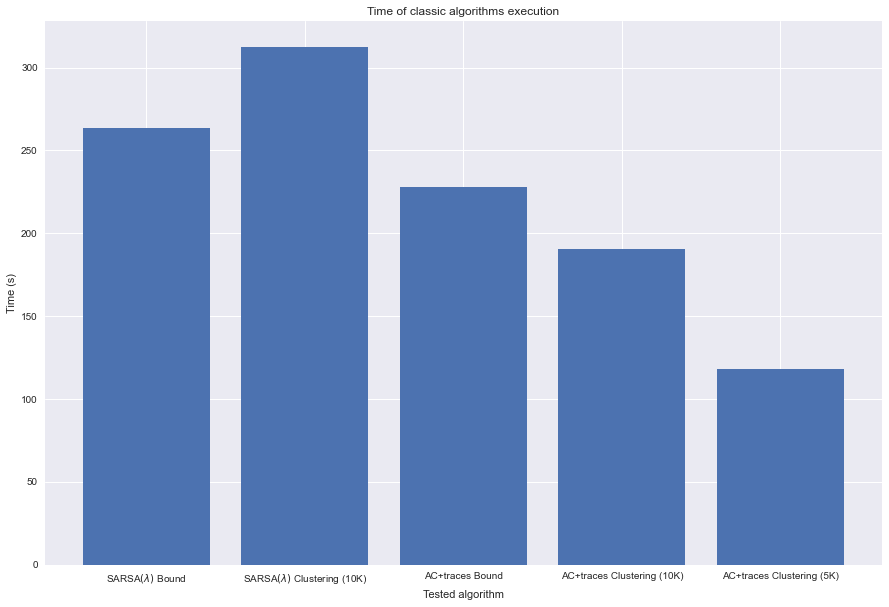

In [45]:
times_classic = [t_sl_bound, t_sl_clust_10, t_ac_bound, t_ac_clust_10, t_ac_clust_5]
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(['SARSA$(\lambda)$ Bound', 'SARSA$(\lambda)$ Clustering (10K)', 'AC+traces Bound', 'AC+traces Clustering (10K)', 'AC+traces Clustering (5K)'],
       times_classic)
ax.set_title('Time of classic algorithms execution')
ax.set_xlabel('Tested algorithm')
ax.set_ylabel('Time (s)');

plt.savefig(join(FIGDIR, 'classic', 'Time of classic algorithms execution.png'), dpi=300, bbox_inches='tight')

### Advanced algorithms

In [17]:
class DiscreteToBoxWrapper(gym.ActionWrapper):
    def __init__(self, env, new_action_set):
        super().__init__(env)
        self.new_action_set = new_action_set
        self.action_space = gym.spaces.Box(low=np.array([0, 1]), high=np.array([1, 5.999]))
        
    def action(self, box_act):
        if box_act[0] < 0.5:
            action = self.new_action_set[0]
        else:
            action = self.new_action_set[int(np.floor(box_act[1]))]
        return action
    
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

#### PPO, EvalCallback

In [18]:
start_time = time.time()
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))))

eval_callback = EvalCallback(slime_env,
                             eval_freq=100_000,
                             n_eval_episodes=100)

ppo_model = PPO('MlpPolicy', slime_env, verbose=0)

ppo_model.learn(100_000, callback=eval_callback);
end_time = time.time()

Eval num_timesteps=100000, episode_reward=0.88 +/- 1.09
Episode length: 576.90 +/- 94.09
New best mean reward!


In [19]:
t_ppo_eval = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ppo_eval))

--- Elapsed time: 148.22693848609924 seconds ---


#### PPO, no EvalCallback

In [20]:
start_time = time.time()
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))))

ppo_model = PPO('MlpPolicy', slime_env, verbose=0)

ppo_model.learn(100_000);
end_time = time.time()

In [21]:
t_ppo = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ppo))

--- Elapsed time: 132.92537784576416 seconds ---


#### DQN

In [22]:
start_time = time.time()
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))))

dqn_model = DQN('MlpPolicy', slime_env, verbose=1)

dqn_model.learn(100_000);
end_time = time.time()

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 675      |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.744    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5574     |
|    time_elapsed     | 0        |
|    total_timesteps  | 2699     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 622      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5954     |
|    time_elapsed     | 0        |
|    total_timesteps  | 4980     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 620      |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.293    |
| t

In [23]:
t_dqn = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_dqn))

--- Elapsed time: 58.821918964385986 seconds ---


#### SAC

In [24]:
start_time = time.time()
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)


slime_env = Monitor(env=SurvivalRewardEnv(DiscreteToBoxWrapper(ReducedDimension(gym.make('SlimeVolley-v0')), action_table)))

model = SAC('MlpPolicy', slime_env, verbose=1)

model.learn(10_000);
end_time = time.time()

Using cpu device
Wrapping the env in a DummyVecEnv.


c:\Users\Andres\anaconda3\envs\rl-slime\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 545      |
|    ep_rew_mean     | 0.45     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 48       |
|    time_elapsed    | 45       |
|    total_timesteps | 2180     |
| train/             |          |
|    actor_loss      | -10.6    |
|    critic_loss     | 0.0697   |
|    ent_coef        | 0.536    |
|    ent_coef_loss   | -2.09    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2079     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 554      |
|    ep_rew_mean     | 0.535    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 45       |
|    time_elapsed    | 96       |
|    total_timesteps | 4428     |
| train/             |          |
|    actor_loss      | -13.8    |
|    critic_loss     | 0.09     |
|    ent_coef 

In [25]:
t_sac = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_sac))

--- Elapsed time: 221.9651234149933 seconds ---


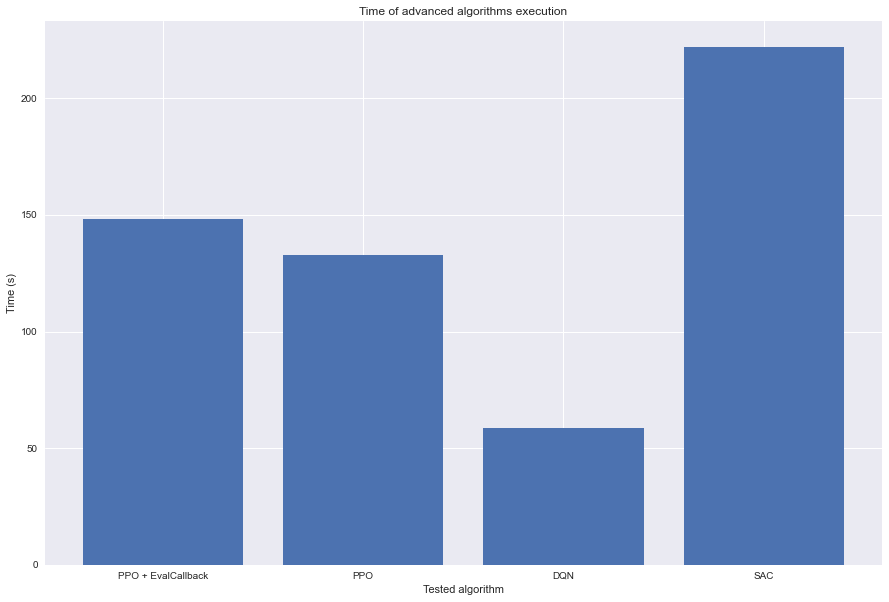

In [46]:
times_advanced = [t_ppo_eval, t_ppo, t_dqn, t_sac]
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(['PPO + EvalCallback', 'PPO', 'DQN', 'SAC'], times_advanced)
ax.set_title('Time of advanced algorithms execution')
ax.set_xlabel('Tested algorithm')
ax.set_ylabel('Time (s)');

plt.savefig(join(FIGDIR, 'advanced', 'Time of advanced algorithms execution.png'), dpi=300, bbox_inches='tight')